In [204]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy import stats


from scipy.stats import rankdata
import pandas as pd

from utils import get_low_variance_objects

In [148]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

In [207]:
class GRank:
    def __init__(self):
        self.half_range = 0.99
        self.range = self.half_range*2
        self.mapper = {}

    def fit(self, X):
        self.min = X.min() 
        self.max = X.max() 
        rank =  rankdata(X) 
        scale =  self.range/len(rank)
        
    def transform(self,X):
        X = np.where(X <= self.min, self.min, X)
        X = np.where(X >= self.max, self.max, X)
        rank =  rankdata(X) 
        scale =  self.range/len(rank)
        rank = rank*scale - self.half_range
        return erfinv(rank)
    
class GpandasRanker:
    def __init__(self):
        self.rankers = {}

    def fit(self, d_set, columns):
        for col in columns:
            X = d_set[col].values
            ranker = GRank()
            ranker.fit(X)
            self.rankers[col] = ranker

    def transform(self, d_set):
        d_set = d_set.copy()
        for col in self.rankers:
            d_set[col] = self.rankers[col].transform(d_set[col].values)
        return d_set

In [151]:
class RealNormalizer:
    def __init__(self):
        self.mapper = dict()
    
    def fit_transform(self, data, columns_to_normalize):
        for col in columns_to_normalize:
            mean, std = data[col].mean(), data[col].std()
            if std == 0: continue
            self.mapper[col] = (mean, std)          
            data[col] = ((data[col] - mean)/std).astype(float)
        
        return data
    
    def transform(self, data):
        for col in self.mapper:
            mean, std = self.mapper[col]
            data[col] = ((data[col] - mean)/std).astype(float)
        
        return data

In [226]:
import pandas as pd

train = pd.read_csv('/home/dev/data_main/homesite/TRAIN.csv').sample(5000)
val = pd.read_csv('/home/dev/data_main/homesite/VAL.csv').sample(5000)

val.drop(['Unnamed: 0'], axis=1, inplace=True)
train.drop(['Unnamed: 0'], axis=1, inplace=True)

train.fillna(train.median(), inplace=True)
val.fillna(train.median(), inplace=True)

TARGET = 'TARGET'

### GET CAT & REAL FEATURES

In [227]:
low_var_objects, high_var_objects, low_var_real = get_low_variance_objects(train.drop(TARGET, axis=1), th=100)

Low variance items all: 295, Objects all: 28
Low variance objects: 27, High var objects: 1


In [228]:
train.drop(list(low_var_objects) + list(high_var_objects), axis=1, inplace=True)
val.drop(list(low_var_objects) + list(high_var_objects), axis=1, inplace=True)

In [229]:
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score)

model = LogisticRegression(penalty ='l2',random_state = 0,solver = 'lbfgs',n_jobs = -1, C=1)

model.fit(train.drop(TARGET, axis=1), train[TARGET])
preds = model.predict_proba(val.drop(TARGET, axis=1))
roc_auc_score(val[TARGET], preds[:,1])

0.7556724642962849

In [230]:
categoical = low_var_objects.union(low_var_real)
low_var_n_objects = categoical.union(high_var_objects)
real_features = list(set(train.columns).difference(low_var_n_objects))
real_features.remove(TARGET)

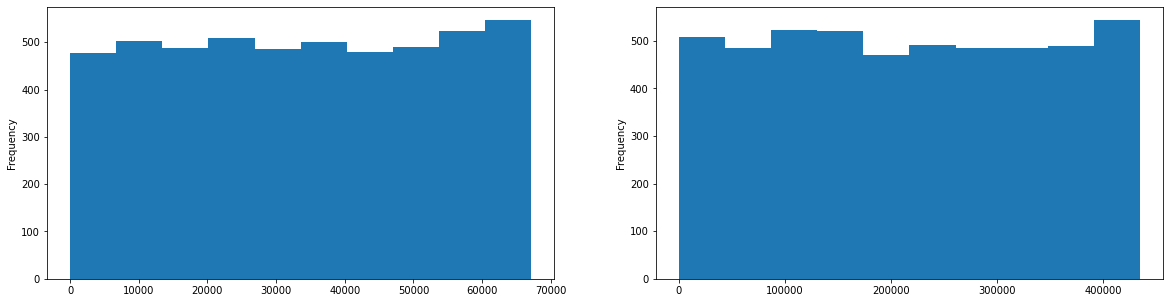

In [231]:
fig, ax = plt.subplots(1, len(real_features[:4]), figsize=(20, 5))

for i in range(len(real_features[:4])):
    train[real_features[i]].plot(kind='hist', ax = ax[i])

## GRank Transform

In [232]:
g_pandas = GpandasRanker()
g_pandas.fit(train, real_features)

In [233]:
train_gr = g_pandas.transform(train)
val_gr = g_pandas.transform(val)

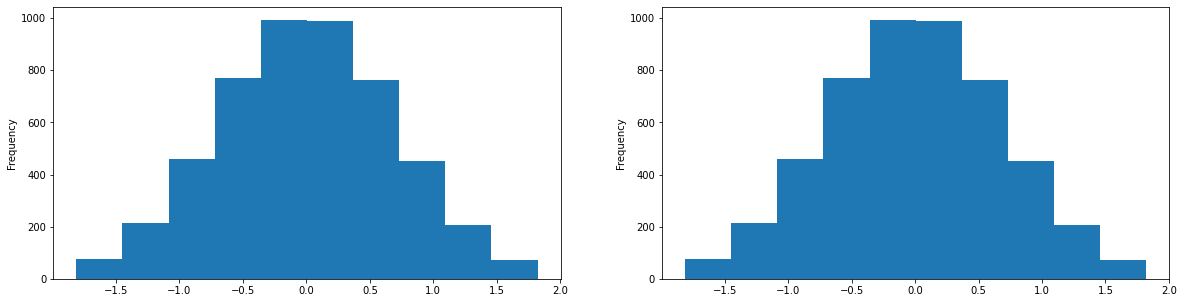

In [234]:
fig, ax = plt.subplots(1, len(real_features), figsize=(20, 5))
for i in range(len(real_features)):
    train_gr[real_features[i]].plot(kind='hist', ax = ax[i])

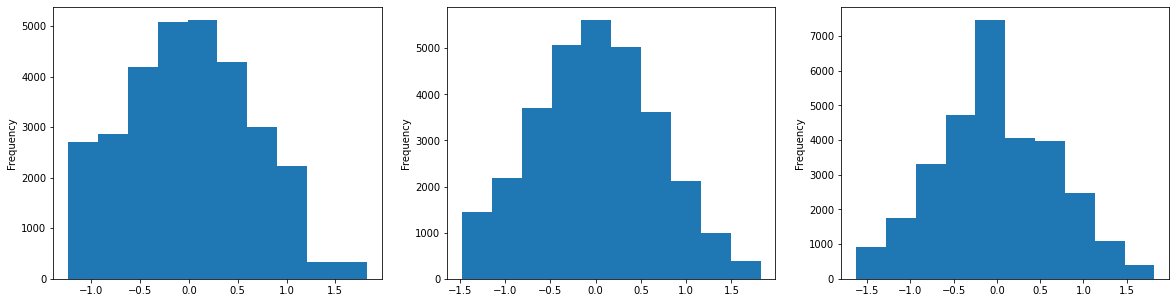

In [212]:
fig, ax = plt.subplots(1, len(real_features), figsize=(20, 5))
for i in range(len(real_features)):
    val_gr[real_features[i]].plot(kind='hist', ax = ax[i])

## GRank results

In [235]:
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score)

model = LogisticRegression(penalty ='l2',random_state = 0,solver = 'lbfgs',n_jobs = -1, C=1)

model.fit(train_gr.drop(TARGET, axis=1), train_gr[TARGET])
preds = model.predict_proba(val_gr.drop(TARGET, axis=1))
roc_auc_score(val_gr[TARGET], preds[:,1])

0.8725501916451358

### BOX COX

In [237]:
normalizer = RealNormalizer()

# box cox
# transform training data & save lambda value
#train[real_features[2]],fitted_lambda = stats.boxcox(train[real_features[2]]+1)
# use lambda value to transform test data
#val[real_features[2]] = stats.boxcox(val[real_features[2]]+1, fitted_lambda)

#train[real_features[1]],fitted_lambda = stats.boxcox(train[real_features[1]]+1)
#val[real_features[1]] = stats.boxcox(val[real_features[1]]+1, fitted_lambda)
 
#SCORE if higher if do not do this transformation

#transform training data & save lambda value
train[real_features[0]],fitted_lambda = stats.boxcox(train[real_features[0]]+1)
#use lambda value to transform test data
val[real_features[0]] = stats.boxcox(val[real_features[0]]+1, fitted_lambda)

# min max
train = normalizer.fit_transform(train, real_features)
val = normalizer.transform(val)

In [238]:
model = LogisticRegression(penalty ='l2',random_state = 0,solver = 'lbfgs',n_jobs = -1, C=1)

model.fit(train.drop(TARGET, axis=1), train[TARGET])
preds = model.predict_proba(val.drop(TARGET, axis=1))
roc_auc_score(val[TARGET], preds[:,1])

0.8720032736085847